In [1]:
%%capture
!pip install db-dtypes
!pip install keras
!pip install tensorflow

In [2]:
%%capture
%logstop
%logstart -t -r -q ipython_command_log.py global

#- IRONHACKS RESEARCH TRACKING CODE
#----------------------------------
# The following code is used to help our research team understand how you 
# our notebook environment. We do not collect any personal information with
# the following code, it is used to measure when and how often you work on
# your submission files.

import os
from datetime import datetime
import IPython.core.history as history

ha = history.HistoryAccessor()
ha_tail = ha.get_tail(1)
ha_cmd = next(ha_tail)
session_id = str(ha_cmd[0])
command_id = str(ha_cmd[1])
timestamp = datetime.utcnow().isoformat()
history_line = ','.join([session_id, command_id, timestamp]) + '\n'
logfile = open(os.environ['HOME']+'/ipython_session_log.csv', 'a')
logfile.write(history_line)
logfile.close()

In [3]:
%%capture
import pandas as pd
import numpy as np
import os
from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud.bigquery import magics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ElasticNetCV
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dropout, Dense
from keras.models import load_model
import joblib
from joblib import Parallel, delayed
from scipy import stats
from sklearn.ensemble import IsolationForest

2022-12-06 03:01:14.190846: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-06 03:01:14.338146: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-06 03:01:14.338176: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-06 03:01:15.023102: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

### Retrieve Data, EDA and Data Cleaning

In [4]:
BIGQUERY_PROJECT = 'ironhacks-data'
bigquery_client = bigquery.Client(project=BIGQUERY_PROJECT)

In [5]:
query_main = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.unemployment_data`
"""

query_job = bigquery_client.query(query_main)
unemployment_data = query_job.to_dataframe()

In [6]:
query = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.wage_data`
"""

query_job = bigquery_client.query(query)
wage_data = query_job.to_dataframe()

In [7]:
query_pred = """
SELECT * 
FROM `ironhacks-data.ironhacks_competition.prediction_list`
"""

query_job = bigquery_client.query(query_pred)
prediction_list = query_job.to_dataframe()

In [ ]:
print(unemployment_data.info())
print(wage_data.info())

In [ ]:
# check shape of both frames to see if they are joinable
print('Unemployment df size:', unemployment_data.shape)
print('Wage df size:', wage_data.shape)

##### Small EDA to validate data contents for additional preprocessing

In [ ]:
unemployment_data.isnull().sum() / len(unemployment_data) * 100

In [ ]:
wage_data.isnull().sum() / len(wage_data) * 100

I've concluded that imputing the 'NA' values in the data with 0s is a temporary solution to dealing with this dataset, until I can figure out a better way to engineer these features correctly. 
It appears the values for each variable are the summation of each respondent that meets variable criterion, that cannot exceed the value specified under the 'total_claims' column. I will use this column as a beacon. 

It is likely that questions regarding race were not answered fully or were skipped during collection - so expect some discrepancies.

In [ ]:
# replace values with 0
clean_unemploymentDf = unemployment_data.copy()
clean_unemploymentDf.fillna(0, inplace=True)
clean_unemploymentDf

In [ ]:
clean_unemploymentDf.isnull().sum() #check

In [ ]:
%%capture
unemp_dupl = clean_unemploymentDf[clean_unemploymentDf.duplicated()]
print('Duplicate rows: ', unemp_dupl)
# ignore duplicates - different time periods

In [ ]:
# check correlation
correlation = clean_unemploymentDf.corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))
plt.figure(figsize=(15,10))
sns.heatmap(correlation, mask=mask, annot=True, fmt='.2f')

In [ ]:
# check wage information
wage_data[wage_data['average_wage'].isnull()] # there's 3 nulls here - might as well drop them and use this tract to attempt to join the datasets together; or impute with mean

In [ ]:
#wage_data.dropna(axis=0, inplace=True)
wage_data['average_wage'].fillna(wage_data['average_wage'].mean(), inplace=True)
wage_data.isnull().sum()

In [ ]:
wage_dupl = wage_data[wage_data.duplicated()]
print('Duplicate rows: ', wage_dupl)

In [ ]:
# join df on tract
main_df = pd.merge(clean_unemploymentDf, wage_data, on=['tract', 'uu_id'], how='outer')

In [ ]:
main_df

In [ ]:
# drop columns created by merge and rename existing columns to original
main_df.drop(['countyfips_y','tract_name_y'], axis=1, inplace=True)
main_df.rename({'countyfips_x':'countyfips', 'tract_name_x':'tract_name'}, axis=1, inplace=True)

In [ ]:
main_df.isnull().sum() # check again

In [ ]:
main_df.dropna(axis=0, inplace=True) #most of the rows with NA values have nothing to add and cannot be imputed

In [ ]:
# check correlation again for new, merged frame
correlation = main_df.corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))
plt.figure(figsize=(15,10))
sns.heatmap(correlation, mask=mask, annot=True, fmt='.2f')

In [ ]:
main_df.isnull().sum()

In [ ]:
# main df analytics
main_df.describe()

In [ ]:
main_df.columns

In [ ]:
timeline = main_df.groupby('week_number', as_index=False)['total_claims'].sum()

In [ ]:
timeline

In [ ]:
# total claims over each week
plt.figure(figsize=(15,10))
sns.barplot(data=timeline, x = 'week_number', y = 'total_claims')

In [ ]:
# race demographics
race_demographics = main_df.groupby(['week_number'], as_index=False)['race_amerindian','race_asian','race_black','race_noanswer','race_hawaiiannative','race_other','race_white','total_claims'].sum()

In [ ]:
plt.figure(figsize=(15,10))
sns.barplot(race_demographics, x= 'week_number', y='race_amerindian')

In [ ]:
plt.figure(figsize=(15,10))
sns.barplot(race_demographics, x= 'week_number', y='race_asian')

In [ ]:
plt.figure(figsize=(15,10))
sns.barplot(race_demographics, x= 'week_number', y='race_black')

In [ ]:
plt.figure(figsize=(15,10))
sns.barplot(race_demographics, x= 'week_number', y='race_noanswer')

In [ ]:
plt.figure(figsize=(15,10))
sns.barplot(race_demographics, x= 'week_number', y='race_hawaiiannative')

In [ ]:
plt.figure(figsize=(15,10))
sns.barplot(race_demographics, x= 'week_number', y='race_other')

In [ ]:
plt.figure(figsize=(15,10))
sns.barplot(race_demographics, x= 'week_number', y='race_white')

In [ ]:
# gender demographics
gender_demographics = main_df.groupby(['week_number'], as_index=False)['gender_female', 'gender_male', 'gender_na','total_claims'].sum()

In [ ]:
# lets try a different plot method, seaborn is nice but strict in format
gender_demographics.plot(x='week_number', y=['gender_female','gender_male','gender_na'], kind='bar', figsize=(20,10))
plt.xlabel('week_number')
plt.ylabel('gender_sums')
plt.title('Recorded Gender Sum')
plt.xticks(rotation=30, horizontalalignment='center')

In [ ]:
# education?
edu_hist = main_df.groupby(['week_number'], as_index=False)['edu_8th_or_less', 'edu_grades_9_11', 'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown',].sum()

In [ ]:
edu_hist.plot(x='week_number', y=['edu_8th_or_less','edu_grades_9_11','edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown'], kind='bar', figsize=(20,10))
plt.xlabel('week_number')
plt.ylabel('education_sums')
plt.title('Recorded Education Sum')
plt.xticks(rotation=30, horizontalalignment='center')

### General impressions
From the correlation matrix, there's more than a few positive correlations with the target variable - but dropping these might remove essential information. While they are not "strongly" correlated, they do tell us that there are relationships between education and race when it comes to unemployment. The only exceptions are the gender variables for male and female. 

There also appears to be a spike in total claims during the last few weeks (aggregated by sum). 

If we look at race demographics, considering that this is survey data - there are more respondents that are either black or white compared to others, such as Indian-Americans, Asians, Hawaiian Natives, or other races. This however, does not mean that each respondent in this dataset has filed an unemployment claim. 

There are also more males than female respondents within this dataset, though this is unlikely to have an effect on the data on the whole.

Most respondents also appear to have a GED equivalent - followed by post HS education.

## Models
Since this is a regression task, I'll start with SVM and Random Forests, then move from there.

In [ ]:
#prediction_list.to_csv('prediction_list.csv')

In [8]:
def evaluate_regressor(prediction_dataframe):
    # Takes in a prediction dataframe of 2 columns, Actual values and Predicted values generated by a regressor
    # Outputs MSE, MAR, RMSE and MAPE metrics. Must have columns named Actual and Predicted.
    print('MSE:', mean_squared_error(prediction_dataframe['Actual'], prediction_dataframe['Predicted']))
    print('MAE:', mean_absolute_error(prediction_dataframe['Actual'], prediction_dataframe['Predicted']))
    print('RMSE:', np.sqrt(mean_squared_error(prediction_dataframe['Actual'], prediction_dataframe['Predicted'])))
    print('MAPE:', np.mean(np.abs((prediction_dataframe['Actual'] - prediction_dataframe['Predicted']) / prediction_dataframe['Actual'])) * 100)

In [38]:
def get_predictions(regressor, model_type, name, week):
    # generates predictions for any model and writes out a dataframe in csv containing them
    # takes a regressor and learning method type as input: DL and ML
    # DL/ML variable basically changes the shape for an input from a 2D array to 3D arry, as required tensor shape
    result_list = []
    uu_id_transform = LE.fit_transform(prediction_list['uu_id'])
    if model_type == 'DL':
        predict_arr = np.array(SC_other.transform([[0, 1, 6, 4, 4, 5, 0, 1, 2, 0, 4, 1, 4200.0]]))
        for val in uu_id_transform:
            to_predict = np.insert(predict_arr, 0, val, axis=1)
            to_predict = np.insert(to_predict, 1, week, axis=1)
            to_predict = np.reshape(to_predict, (to_predict.shape[0], to_predict.shape[1],1))
            r = regressor.predict(to_predict)
            result_list.append(r)
        result_list = np.array(result_list)
        result_list = np.reshape(result_list, (525,))
    elif model_type == 'ML':
        predict_arr = np.array(RB_other.transform([[0, 1, 6, 4, 4, 5, 0, 1, 2, 0, 4, 1, 4200.0]]))
        for val in uu_id_transform:
            to_predict = np.insert(predict_arr, 0, val, axis=1)
            to_predict = np.insert(to_predict, 1, week, axis=1)
            r = regressor.predict(to_predict)
            result_list.append(r)
    result_df = pd.DataFrame(result_list, columns = ['Predictions'])
    prediction_sub = prediction_list.copy()
    prediction_sub['total_claims'] = result_df.values
    prediction_sub = prediction_sub[['uu_id','total_claims','week_number']]
    os.makedirs('lost+found/submission_files', exist_ok=True)
    prediction_sub.to_csv('lost+found/submission_files/'+name+'.csv', index=False)
    return prediction_sub

In [10]:
def get_pred_frame(test_frame, prediction_array):
    prediction_frame = pd.DataFrame({'Actual': test_frame, 'Predicted': prediction_array.flatten()})
    return prediction_frame

In [11]:
def clearOutlier_IQR(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    no_outliers = data[~((data < (Q1 - 1.5 * IQR)) |(data > (Q3 + 1.5 * IQR))).any(axis=1)]
    print(no_outliers.shape)
    return no_outliers

In [12]:
# outlier detection and handling - Z Score (gaussian only)
def clearOutlier_ZScore(data, threshold):
    zscore = np.abs(stats.zscore(data))
    thresh = threshold
    no_outliers = data[(zscore < thresh).all(axis=1)]
    return no_outliers

In [13]:
# outlier detection - automatic
def IsoForest_anomaly(data):
    IFO = IsolationForest(random_state=69)
    col_list = ['week_number', 'total_claims', 'edu_8th_or_less',
                'edu_grades_9_11', 'edu_hs_grad_equiv', 'edu_post_hs', 'gender_female',
                'gender_male', 'race_amerindian', 'race_asian', 'race_black',
                'race_hawaiiannative', 'race_other', 'race_white', 'average_wage']
    NO_df = data.copy()
    IFO.fit(data)
    NO_df['anomaly_scores'] = IFO.decision_function(data)
    NO_df['anomaly'] = IFO.predict(data)
    no_outlier = NO_df[NO_df['anomaly'] == 1]
    print('Removed ', NO_df[NO_df['anomaly'] == -1].shape[0], 'datapoints')
    palette = ['#ff7f0e','#1f77b4']
    sns.pairplot(NO_df, vars = col_list, hue='anomaly', palette=palette)
    no_outlier.drop(['anomaly_scores','anomaly'], axis = 1, inplace=True)
    return no_outlier

In [14]:
def preprocess(data, scaling):
    no_outlierDF = ingest.copy()
    to_drop = ['timeperiod','tract','top_category_employer1','top_category_employer2',
           'top_category_employer3','tract_name','countyfips', 'edu_unknown', 'gender_na', 
           'race_noanswer']
    to_scale = ['edu_8th_or_less', 'edu_grades_9_11', 'edu_hs_grad_equiv', 'edu_post_hs', 
            'gender_female', 'gender_male', 'race_amerindian', 'race_asian', 'race_black', 
            'race_hawaiiannative', 'race_other', 'race_white', 'average_wage']
    no_outlierDF.drop(to_drop, axis=1, inplace=True)
    no_outlierDF['uu_id'] = LE.fit_transform(no_outlierDF['uu_id'])
    if scaling == 'Robust':
        no_outlierDF[to_scale] = RB_other.fit_transform(no_outlierDF[to_scale])
    elif scaling == 'Standard':
        no_outlierDF[to_scale] = SC_other.fit_transform(no_outlierDF[to_scale])
    return no_outlierDF

In [ ]:
# data specifically for models to ingest
# ingest = main_df.copy()

In [ ]:
# get old data for previous week saved in env
# old_ingest = pd.read_csv('lost+found/submission_files/ingest.csv', index_col=0)
# concat to form a single dataset
# merged_ingest = pd.concat([old_ingest, ingest])
# add new data
# combined_ingest = pd.read_csv('lost+found/submission_files/combined_ingest.csv')

In [15]:
# updated_ingest = pd.concat([merged_ingest, combined_ingest])
ingest = pd.read_csv('lost+found/submission_files/complete_ingest.csv')

In [ ]:
#new_data = main_df.copy()
#complete_ingest = pd.concat([ingest, new_data])
#complete_ingest.shape

In [ ]:
#complete_ingest.isnull().sum()

In [ ]:
#print(complete_ingest.shape)
#print(ingest.shape)

In [ ]:
# complete_ingest.dropna(axis=0, inplace=True)

In [ ]:
# complete_ingest.shape

In [ ]:
# check if new data is duplicate
# complete_ingest.equals(main_df)

In [ ]:
## write out combined data for use later
# os.makedirs('lost+found/submission_files', exist_ok=True)
# complete_ingest.to_csv('lost+found/submission_files/complete_ingest.csv', index=False)

In [ ]:
# shuffle the data - is this really necessary?
# merged_ingest = merged_ingest.sample(frac=1)

In [13]:
ingest.dropna(axis=0, inplace=True)
print(ingest.shape)

(86124, 26)


In [16]:
# quick preprocess to keep uu_id and scale values
from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler
LE = LabelEncoder()
RB_other = RobustScaler()
SC_other = StandardScaler()
# RB_claims = RobustScaler()

Removed  9736 datapoints


/tmp/ipykernel_436/896955743.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_outlier.drop(['anomaly_scores','anomaly'], axis = 1, inplace=True)


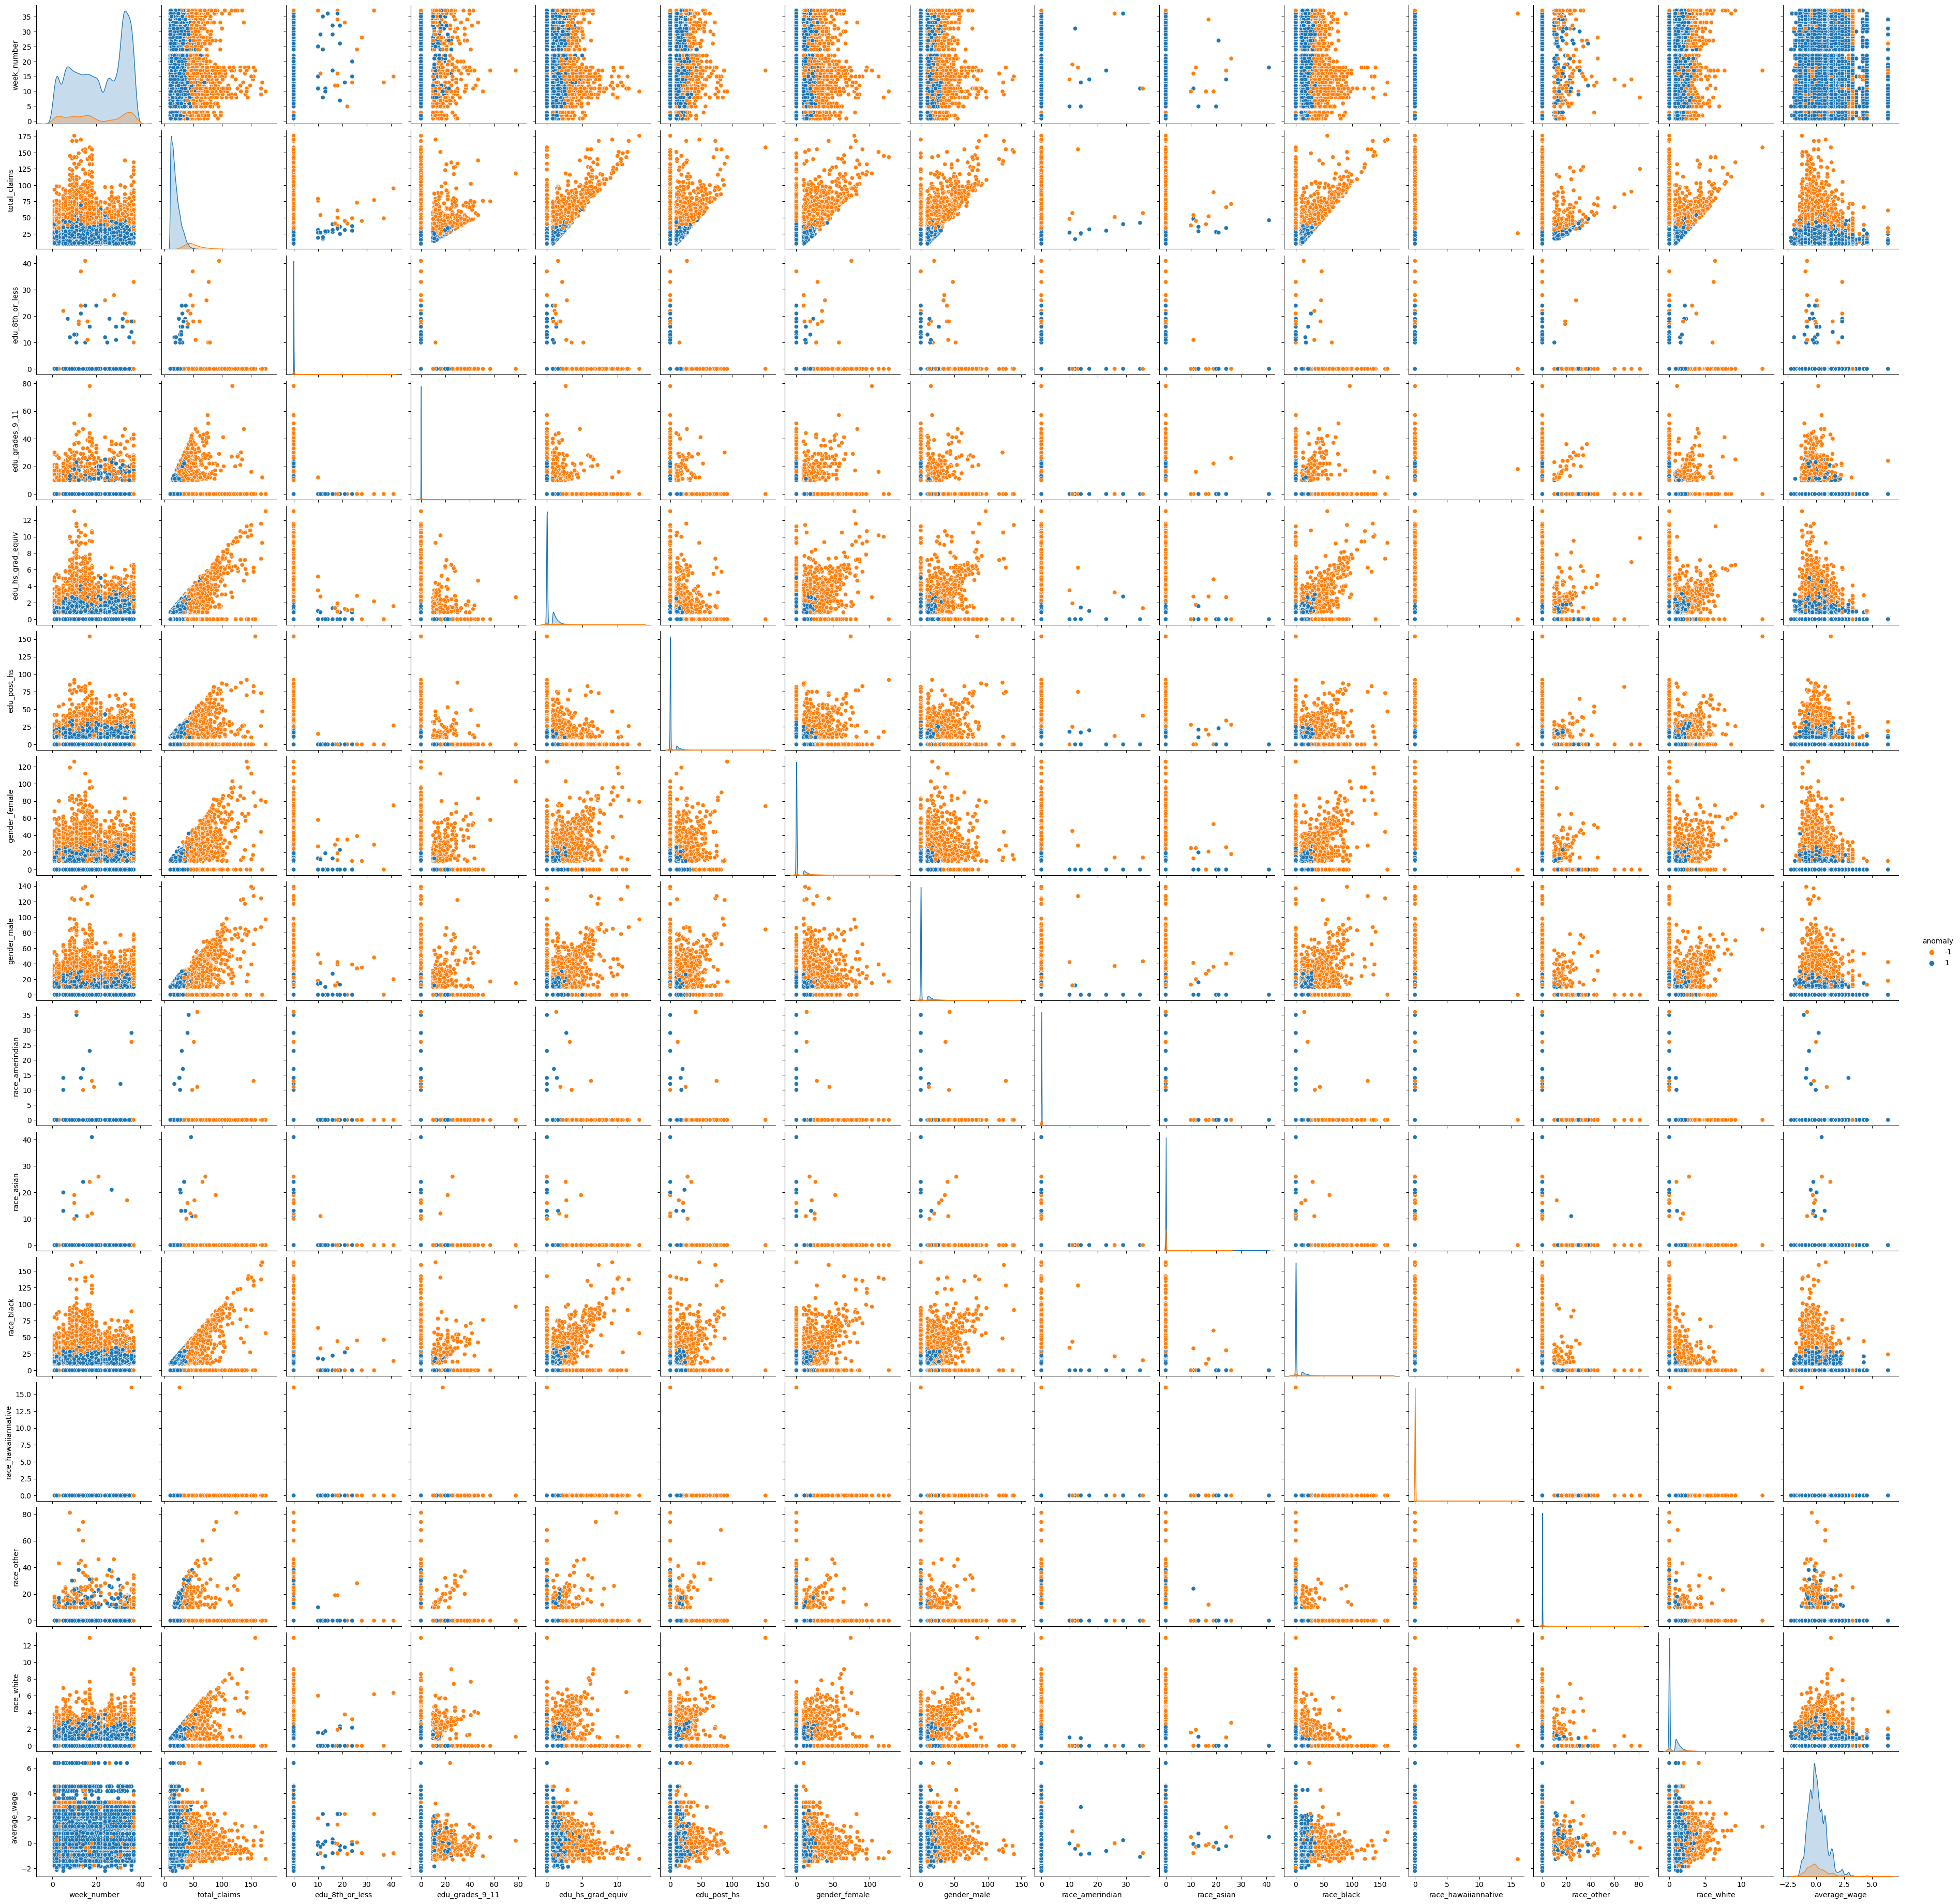

In [17]:
ML_data = preprocess(ingest, 'Robust')
ingest_clean = IsoForest_anomaly(ML_data)

In [18]:
# set target and independent variables
Y = ingest_clean['total_claims']
X = ingest_clean[['uu_id', 'week_number', 'edu_8th_or_less',
                 'edu_grades_9_11', 'edu_hs_grad_equiv', 'edu_post_hs', 'gender_female',
                 'gender_male', 'race_amerindian', 'race_asian', 'race_black',
                 'race_hawaiiannative', 'race_other', 'race_white', 'average_wage']]

In [19]:
# import
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.20, random_state=69)

### SVR

Note: Removed Grid Search code because the last 3 runs on the fit cell took 8 hours. Assumping lack of compute since this runs well locally.

Supervised Learning algorithm from sklearn library used for regression, hence the name Support Vector Regression (SVR). Combined with robust pre-processing - offers robust predictions and is best used with Grid Search. The algorithm was designed initally with Classification tasks in mind but has been extended for Regression tasks in 1996. The intuition of the algorthm is basically to mimimize the error between datapoints using Ordinary Least Squares - but the Regression algorithm uses an Epsilon insensitive tube to determine a margin of error, in order to determine the line of best fit. 

Programmatically, the most important variables within this package/algorithm are the Gamma and C values, which it is best used with a Grid Search or Randomized CV Search, which makes it computationally expensive. If the parameters are set correctly, we can expect accurate results. 

In [ ]:
'''
Regressor_SVR = SVR(kernel ='rbf')
Regressor_SVR.fit(X_train, Y_train)

Y_pred_SVR = Regressor_SVR.predict(X_test).reshape(-1,1)

# evaluate performance
prediction_frame_SVR = pd.DataFrame({'Actual': Y_test, 'Predicted': Y_pred_SVR.flatten()})
prediction_frame_SVR

evaluate_regressor(prediction_frame_SVR)

# what about actual test table?
prediction_list

%%capture
result_list = []
uu_id_transform = LE.fit_transform(prediction_list['uu_id'])
for val in uu_id_transform:
    r = Regressor_SVR.predict([[val, 40, 0.045797, 0.400110, 0.543421, 3.040176, 3.970520, 4.324695, 0.018785, 0.008501, 4.227890, 0.0, 0.217606, 0.517311, 0.106434]])
    result_list.append(r)

# to make things easier, I will be making predictions based on mean of each variable values

result_df = pd.DataFrame(result_list, columns = ['Predictions'])
result_df

prediction_sub = prediction_list.copy()

prediction_sub['total_claims'] = result_df.values
prediction_sub = prediction_sub[['uu_id','total_claims','week_number']]
'''

In [ ]:
# write out submission file
#os.makedirs('lost+found/submission_files', exist_ok=True)
#prediction_sub.to_csv('lost+found/submission_files/submission_prediction_output.csv')

### Random Forests with Grid Search
#### WARNING: *RUNNING  THE  CELL  BELOW  IS  TIME  AND  COMPUTE  INTENSIVE*

Due to compute intensive nature of this model, I have trained this offline (locally) and tested results in this environment. Model has been saved with Joblib (it is extremely large).

In [ ]:
'''
%%capture

from sklearn.ensemble import RandomForestRegressor
Regressor_RF = RandomForestRegressor(random_state=69)
search_space = dict()
search_space['n_estimators'] = np.arange(300,600,100)
search_space['criterion'] = ['squared_error','absolute_error']
search_space['max_features'] = ['sqrt','log2',1.0]
GS = GridSearchCV(estimator=Regressor_RF, param_grid=search_space, cv=3, n_jobs=2, return_train_score=True)

result = GS.fit(X_train,Y_train)

'''

In [ ]:
# result.best_params_

In [ ]:
# Regressor_RF_bestFit = RandomForestRegressor(random_state=69, criterion='squared_error', max_features=1.0, n_estimators= 570)
# Regressor_RF_bestFit.fit(X_train.values, Y_train.values)

In [ ]:
# Y_pred_RFR = Regressor_RF_bestFit.predict(X_test.values).reshape(-1,1)

In [20]:
# load model - next time, I'll need to learn to use PMML
RFR_Regressor = joblib.load('RF_v1-7.pkl')

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.1.3 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.1.3 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [21]:
Y_pred_RFR = RFR_Regressor.predict(X_test.values).reshape(-1,1)

In [22]:
# evaluate
evaluate_regressor(get_pred_frame(Y_test,Y_pred_RFR))

MSE: 0.8227100007608861
MAE: 0.20827594078132136
RMSE: 0.9070336271389755
MAPE: 1.1574593887935234


In [39]:
# call func
get_predictions(RFR_Regressor, 'ML', 'submission_prediction_output_RFR', 44)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


uu_id  total_claims  week_number
0    5bf51fc2e162d6faf9e3cf79e4198378     19.111667           44
1    420b44cc7e3f55d738df565421e59941     19.845000           44
2    e39c66ecceec76ee8f9f811fa4a2d246     17.976667           44
3    a90462cd11ae4e43144239bf7c4828a4     18.146667           44
4    8b20a6749088c7ff1237983076ebfeaa     18.215000           44
..                                ...           ...          ...
520  46c4f6c75e663b1ca82ea7994e6d83d3     19.553333           44
521  1deebda501712e7595b531b8337bc31a     19.430000           44
522  5a9758f65f001b6432ff31ff64a459d7     19.145000           44
523  e8b3b95e93a6dc7dbb90f4e72e7ac065     18.753333           44
524  932a58530abff8a48558e2a15639d453     18.130000           44

[525 rows x 3 columns]

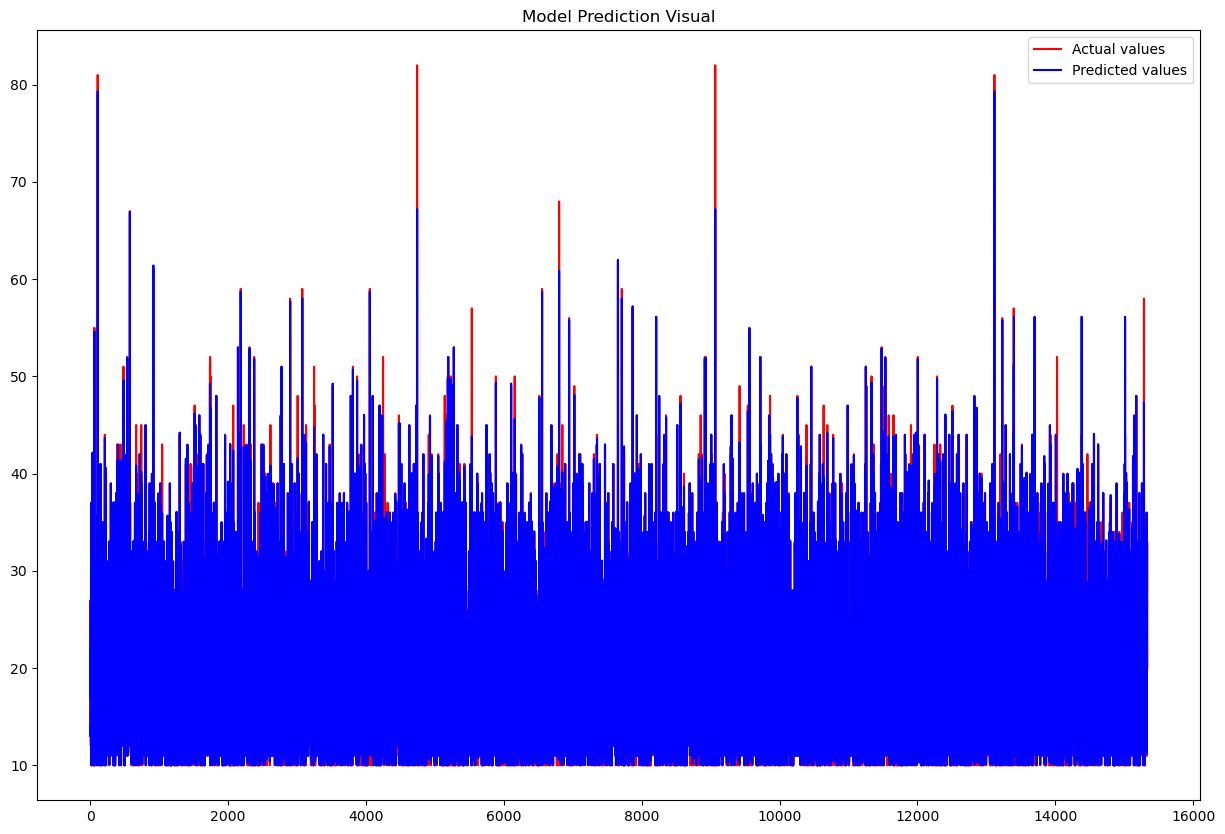

In [24]:
plt.figure(figsize=(15,10))
plt.plot(Y_test.values, color = 'red', label = 'Actual values')
plt.plot(Y_pred_RFR, color='blue', label='Predicted values')
plt.title('Model Prediction Visual')
plt.legend()
plt.show()

### Bayesian Ridge Regression

In [ ]:
# attempting unoptimized model to test 
'''
Regressor_BR = BayesianRidge()
Regressor_BR.fit(X_train, Y_train)

Y_pred_BR = Regressor_BR.predict(X_test).reshape(-1,1)
prediction_frame_BR = pd.DataFrame({'Actual': Y_test, 'Predicted': Y_pred_BR.flatten()})

evaluate_regressor(prediction_frame_BR)
'''

From metrics, this is only slightly better than the SVR but not as good as the RFR model. From sklearn documentation, optimizing with Randomized Search or Grid Search may be too computationally expensive as there are too many parameters to account for. 

Not to mention my inexperience with this specific model.

### Lasso Regression with Repeated K Fold

- Removed Grid Search as the CV class is more effective due to inbuilt alpha search

In [ ]:
'''
cross_valK_Lasso = RepeatedKFold(n_splits=5, n_repeats=3, random_state=69)
Regressor_Lasso = LassoCV(alphas= np.arange(0,1,0.01), cv = cross_valK_Lasso, random_state = 69, n_jobs=-1)

%%capture
Regressor_Lasso.fit(X_train, Y_train)

# capture because of convergence warnings

Y_pred_Lasso = Regressor_Lasso.predict(X_test).reshape(-1,1)

prediction_frame_Lasso = pd.DataFrame({'Actual': Y_test, 'Predicted': Y_pred_Lasso.flatten()})

# evaluate
evaluate_regressor(prediction_frame_Lasso)
'''

Same results; more or less - as the Bayesian Ridge Model. Try something else.

### Elastic Net with Repeated K Fold
#### WARNING: Fit cell takes 1 hour to run

In [ ]:
'''
cross_valK_ENet = RepeatedKFold(n_splits=5, n_repeats=3, random_state=69)
ENet = ElasticNetCV(l1_ratio=np.arange(0.1,1,0.01), cv=cross_valK_ENet, n_jobs=-1)

ENet.fit(X_train, Y_train)

Y_pred_ENet = ENet.predict(X_test).reshape(-1,1)

prediction_frame_ENet = pd.DataFrame({'Actual': Y_test, 'Predicted': Y_pred_ENet.flatten()})

evaluate_regressor(prediction_frame_ENet)
'''

## Deep Learning Section: ENTER AT OWN RISK

### Forward fed stacked LSTM with linear transformation

In [25]:
# this needs different feature engineering, so I'm starting from scratch
DL_data = preprocess(ingest, 'Standard')

Removed  9736 datapoints


/tmp/ipykernel_436/896955743.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_outlier.drop(['anomaly_scores','anomaly'], axis = 1, inplace=True)


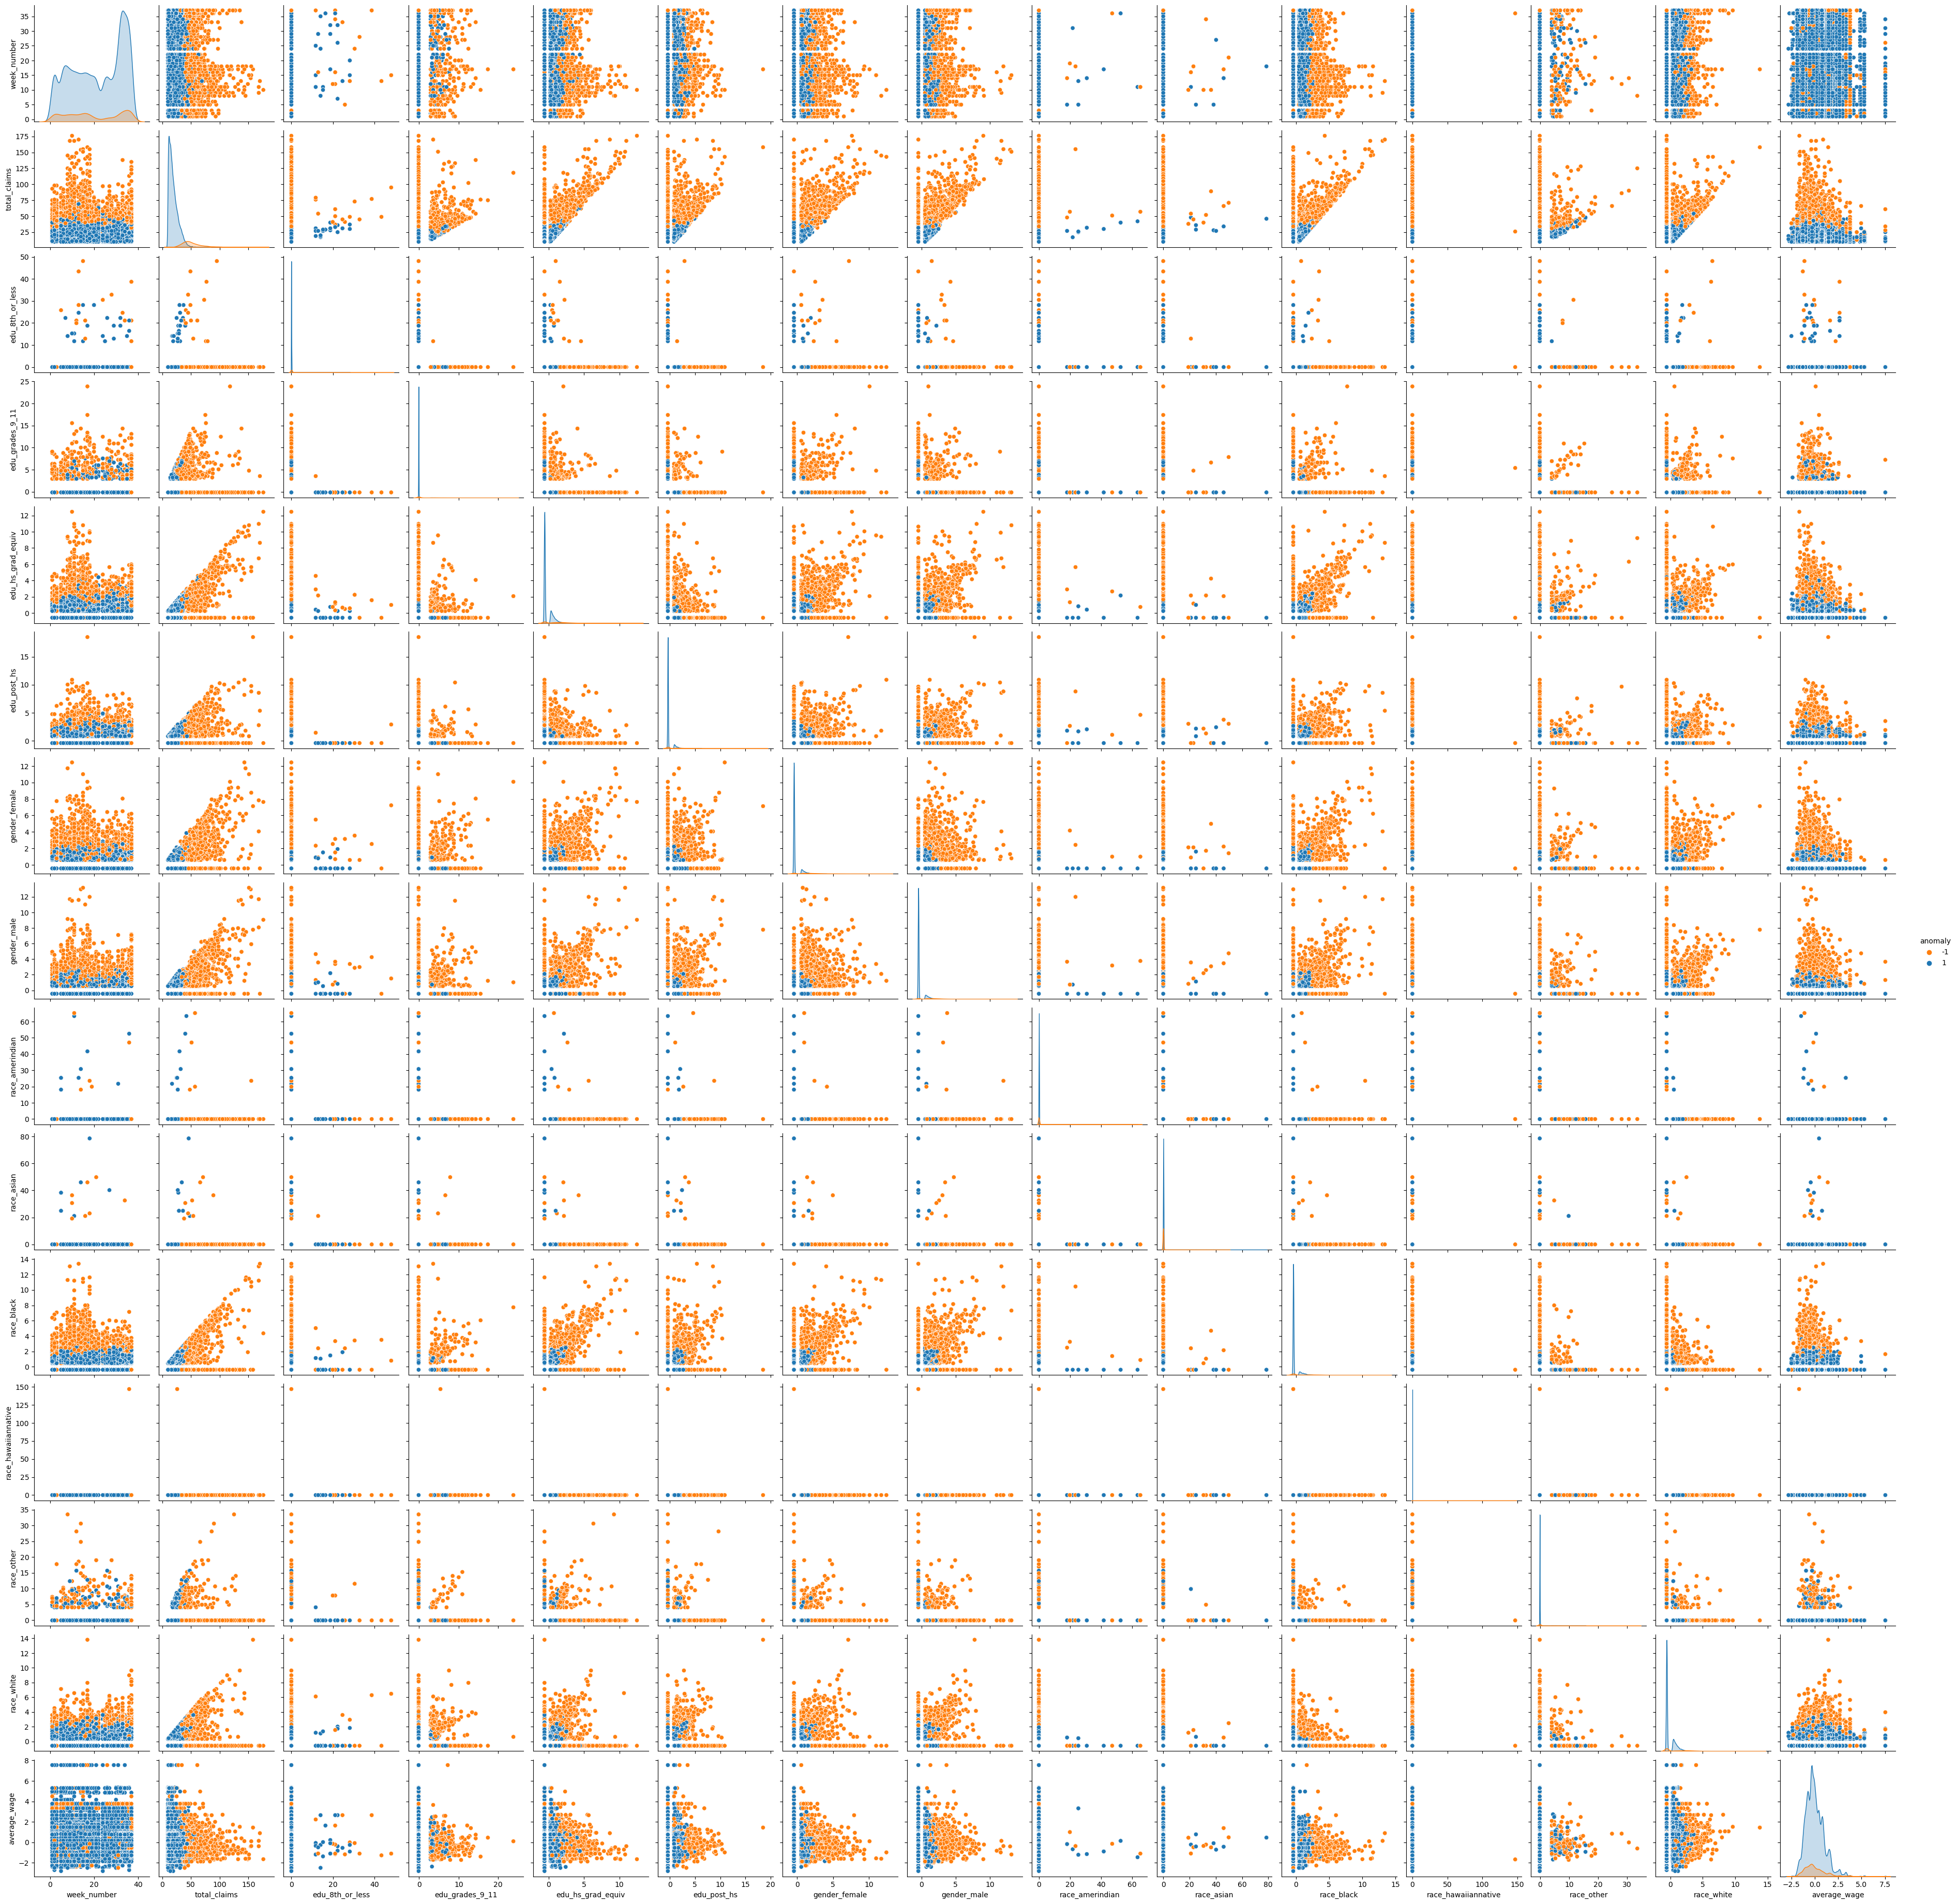

In [26]:
DL_ingest = IsoForest_anomaly(DL_data)

In [27]:
# split set
DL_Y = DL_ingest['total_claims']
DL_X = DL_ingest[['uu_id', 'week_number', 'edu_8th_or_less', 'edu_grades_9_11', 'edu_hs_grad_equiv', 'edu_post_hs', 'gender_female', 'gender_male',
               'race_amerindian', 'race_asian', 'race_black', 'race_hawaiiannative', 'race_other', 'race_white', 'average_wage']]
DL_XTrain, DL_XTest, DL_YTrain, DL_YTest = train_test_split(DL_X, DL_Y, test_size=0.20, random_state=69)

In [28]:
# change to np vectors
DL_XTrain = DL_XTrain.to_numpy()
DL_XTest = DL_XTest.to_numpy()

In [29]:
# reshape because F*** tensors
DL_XTrain = np.reshape(DL_XTrain, (DL_XTrain.shape[0], DL_XTrain.shape[1], 1))

In [30]:
# convert X and Y train to float because input dtype accepts floats only
DL_YTrain = DL_YTrain.astype(float)
DL_XTrain = DL_XTrain.astype(float)

In [ ]:
'''
# start preparing to suffer: Model creation
LSTM_regressor = Sequential()
LSTM_regressor.add(LSTM(units=50, return_sequences=True, input_shape= (DL_XTrain.shape[1], 1)))
LSTM_regressor.add(Dropout(0.2))
LSTM_regressor.add(LSTM(units=50, return_sequences=True))
LSTM_regressor.add(Dropout(0.2))
LSTM_regressor.add(LSTM(units=50, return_sequences=True))
LSTM_regressor.add(Dropout(0.2))
LSTM_regressor.add(LSTM(units=50, return_sequences=False))
LSTM_regressor.add(Dropout(0.2))
LSTM_regressor.add(Dense(units=1))

# compile
LSTM_regressor.compile(optimizer='adam', loss='mean_squared_error')

# fit - pray to the Omnissiah
LSTM_regressor.fit(DL_XTrain, DL_YTrain, epochs=100, batch_size=50)

# change type and rehspe test sets
DL_XTest = DL_XTest.astype(float)

DL_XTest = np.reshape(DL_XTest, (DL_XTest.shape[0], DL_XTest.shape[1],1))
predictions = LSTM_regressor.predict(DL_XTest)

get_pred_frame(DL_YTest, predictions)

evaluate_regressor(get_pred_frame(DL_YTest, predictions))
'''

In [ ]:
'''
plt.figure(figsize=(15,10))
plt.plot(DL_YTest.values, color = 'red', label = 'Actual values')
plt.plot(predictions, color='blue', label='Predicted values')
plt.title('Model Prediction Visual')
plt.legend()
plt.show()
'''

In [ ]:
#get_predictions(LSTM_regressor, 'DL')

### Birectional Stacked LSTM with non-linear transformations

Note: This part will be run locally due to constant kernel kill issues. Assuming compute issue, so the model will be saved and exported here for testing

In [ ]:
#StackLSTM_Regressor = Sequential()
#StackLSTM_Regressor.add(Bidirectional(LSTM(units=50, return_sequences=True, input_shape = (DL_XTrain.shape[1], 1))))
#StackLSTM_Regressor.add(Dropout(0.2))
#StackLSTM_Regressor.add(Bidirectional(LSTM(units=50, return_sequences=True)))
#StackLSTM_Regressor.add(Dropout(0.2))
#StackLSTM_Regressor.add(Bidirectional(LSTM(units=50, return_sequences=False)))
#StackLSTM_Regressor.add(Dropout(0.2))
#StackLSTM_Regressor.add(Bidirectional(LSTM(units=50, return_sequences=True)))
#StackLSTM_Regressor.add(Dropout(0.2))
#StackLSTM_Regressor.add(Bidirectional(LSTM(units=50, return_sequences=False)))
#StackLSTM_Regressor.add(Dropout(0.2))
#StackLSTM_Regressor.add(Dense(units=1, activation='relu'))

In [ ]:
#StackLSTM_Regressor.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
#StackLSTM_Regressor.fit(DL_XTrain, DL_YTrain, epochs=420, batch_size=64)

In [31]:
# load model
StackLSTM_Regressor = load_model('BiDLSTM_v1-05.h5')

2022-12-06 03:38:07.932057: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-06 03:38:07.932099: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-06 03:38:07.932126: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-twinblade02): /proc/driver/nvidia/version does not exist
2022-12-06 03:38:07.942594: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [32]:
# summary for viewers
StackLSTM_Regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 15, 100)          20800     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 15, 100)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 15, 100)          60400     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 15, 100)           0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 100)              60400     
 nal)                                                            
                                                        

In [33]:
# float cast
DL_XTest = DL_XTest.astype(float)
# make predictions
DL_XTest = np.reshape(DL_XTest, (DL_XTest.shape[0], DL_XTest.shape[1],1))
predictions = StackLSTM_Regressor.predict(DL_XTest)

480/480 [==============================] - 4s 6ms/step


In [40]:
get_pred_frame(DL_YTest, predictions)

Actual  Predicted
56161      13  13.186037
43636      14  16.119179
65492      13  11.240608
30323      15  11.398018
15253      16  15.800216
...       ...        ...
28647      18  17.779222
29097      31  31.002876
19795      22  22.427778
9516       33  32.643608
14081      20  20.164291

[15333 rows x 2 columns]

In [41]:
evaluate_regressor(get_pred_frame(DL_YTest, predictions))

MSE: 6.1752843938335795
MAE: 1.314458216612006
RMSE: 2.485011950440798
MAPE: 8.25799390643335


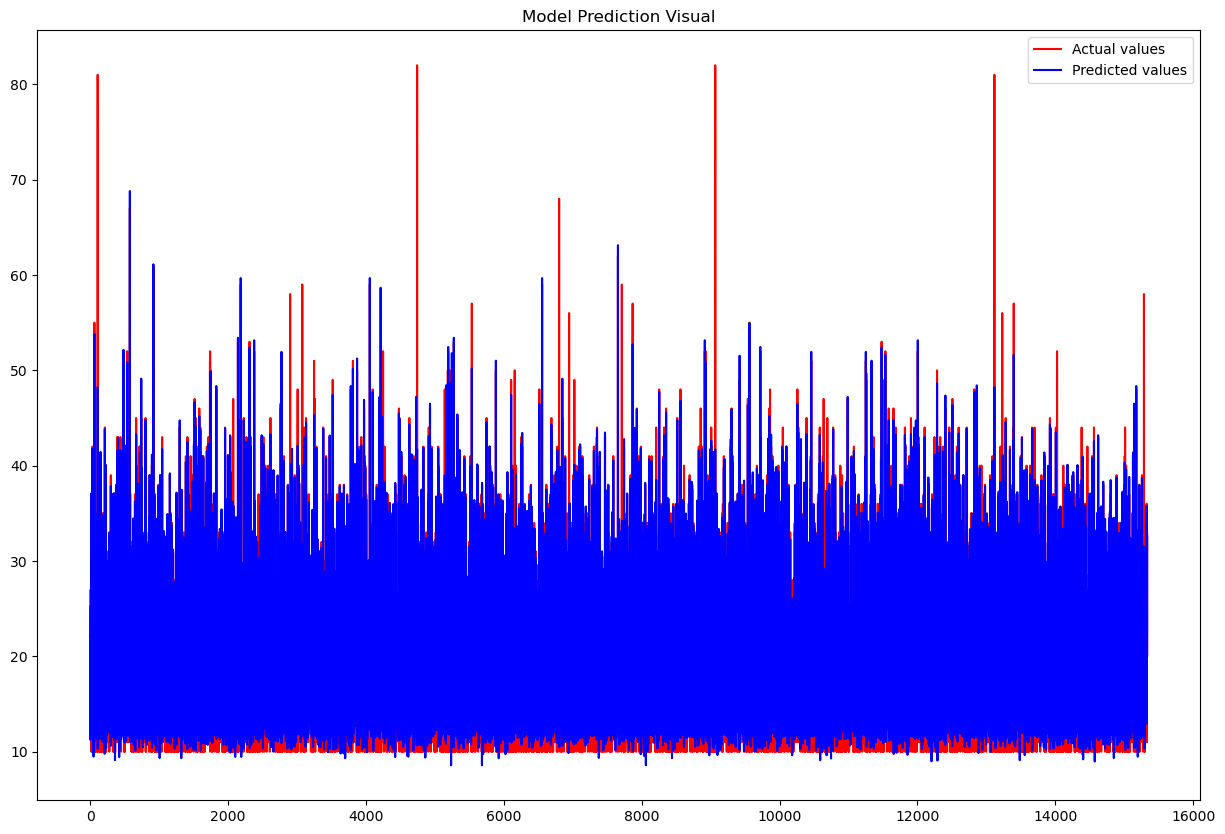

In [36]:
plt.figure(figsize=(15,10))
plt.plot(DL_YTest.values, color = 'red', label = 'Actual values')
plt.plot(predictions, color='blue', label='Predicted values')
plt.title('Model Prediction Visual')
plt.legend()
plt.show()

In [42]:
get_predictions(StackLSTM_Regressor, 'DL', 'submission_prediction_output', 44)

1/1 [==============================] - 0s 28ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 28ms/step


uu_id  total_claims  week_number
0    5bf51fc2e162d6faf9e3cf79e4198378     31.738091           44
1    420b44cc7e3f55d738df565421e59941     32.001991           44
2    e39c66ecceec76ee8f9f811fa4a2d246     32.588760           44
3    a90462cd11ae4e43144239bf7c4828a4     32.453156           44
4    8b20a6749088c7ff1237983076ebfeaa     32.441746           44
..                                ...           ...          ...
520  46c4f6c75e663b1ca82ea7994e6d83d3     32.003506           44
521  1deebda501712e7595b531b8337bc31a     31.635658           44
522  5a9758f65f001b6432ff31ff64a459d7     31.709793           44
523  e8b3b95e93a6dc7dbb90f4e72e7ac065     32.602711           44
524  932a58530abff8a48558e2a15639d453     32.445080           44

[525 rows x 3 columns]

Both LSTMs appear to be underfitting. It is likely that convergence will not be reached unless I use more epochs to train the model - however, due to the complexity of the algorithm - I estimate the time to train this model at approximately 1 day at maximum,
accounting for experimentation with activation function and epochs. Will improve on this model further on. 

Update: Model training was moved offline due to kernel kill issue in environment. Model weights and architecture was saved and uploaded to environment. Test and evaluation will be done here.

Update: Outlier analysis was performed and approximately 9700 datapoints were removed based on an unsupervised classification algorithm called Isolation Forests.
It is clear that the RF model appears to be overfitting, and the RNN model appears to be overfitting lower claim values, and underfitting those on the higher end. The reason for this bamboozles me to this date as MSPE for both algorithms
continues to be high. 

After testing predictions based on more real world values, rather than the mean of all values in the dataset - I've determined that the LSTM is overestimating claims. I would like to submit both models for validation, but for the final submission - the RF moe